In [5]:
%reload_ext autoreload
#%autoreload 2
import xarray as xr 
import numpy as np  
import cftime
import copy
import scipy.stats
from scipy import signal
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xesmf as xe
%matplotlib inline
import matplotlib 
print(matplotlib.__version__)

from SMYLEutils import calendar_utils as cal
from SMYLEutils import stat_utils as stat
from SMYLEutils import mapplot_utils as maps
from SMYLEutils import colorbar_utils as cbars
from SMYLEutils import io_utils as io
from SMYLEutils import regrid_utils as regrid
# import ESP-Lab modules
import data_access
import stats
print("first part done")

3.3.2
first part done


In [6]:
# This preprocessor will return a monthly mean field
def preprocessor(ds0,nlead,field):
    """ This preprocessor is applied on an individual timeseries file basis. Edit this appropriately
    for a your analysis to speed up processing. 
    """
    ds0 = cal.time_set_midmonth(ds0,'time')
    d0 = ds0[field].isel(time=slice(0, nlead))
    d0 = d0.assign_coords({"lon":ds0.lon, "lat":ds0.lat})
    d0 = d0.assign_coords(L=("time", np.arange(d0.sizes["time"])+1))
    d0 = d0.swap_dims({"time": "L"})
    d0 = d0.to_dataset(name=field)
    d0 = d0.reset_coords(["time"])
    d0["time"] = d0.time.expand_dims("Y")
    return d0

In [357]:
%%time
# SMYLE-NOV TREFHT lowtop data
# process all 20 ensemble members, all start dates from 1970-2020:
field = 'PRECT'
#low-top data location
#datadir = '/cw3e/mead/projects/csg100/cesm/scratch/SMYLE-CW3E/timeseries/'
#casename = 'b.e21.BSMYLE-CW3E.f09_g17.????-MM.EEE'
datadir = '/expanse/nfs/cw3e/csg100/_FROM_MEAD_2025.01.07/cesm/scratch/SMYLE-CW3E/timeseries/'
casename = 'b.e21.BSMYLE-CW3E.f09_g17.????-MM.EEE'
filetype = '.cam.h0.'
filetemplate = datadir+casename+'/atm/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
#high-top data location
datadir_high = '/expanse/nfs/cw3e/csg100/_FROM_MEAD_2025.01.07/cesm/scratch/SMYLE-CW3E-L83/timeseries/'
casename_high = 'b.e21.BSMYLE-CW3E-L83.f09_g17.????-MM.EEE'
filetemplate_high = datadir_high+casename_high+'/atm/proc/tseries/month_1/'+casename_high+filetype+field+'.*.nc'
ens = 20 
nlead = 6
inityears = np.arange(1970,2020,1)
startmonth = 2
##change startmonth to 9 for September and 11 for November
chunk = {}
smyle11 = data_access.get_monthly_data(filetemplate,filetype,ens,nlead,field,inityears,startmonth,preprocessor,chunks=chunk)
smyle11_high = data_access.get_monthly_data(filetemplate_high,filetype,ens,nlead,field,inityears,startmonth,preprocessor,chunks=chunk)
print(smyle11_high)
smyle11.nbytes/1e9 #GB
smyle11_high.nbytes/1e9 #GB
print("third part done")

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288, Y: 50, L: 6, M: 20)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * L        (L) int64 1 2 3 4 5 6
  * Y        (Y) int64 1970 1971 1972 1973 1974 ... 2015 2016 2017 2018 2019
  * M        (M) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20
Data variables:
    time     (Y, L) object 1970-02-15 00:00:00 ... 2019-07-15 00:00:00
    PRECT    (Y, L, M, lat, lon) float32 dask.array<chunksize=(1, 6, 1, 192, 288), meta=np.ndarray>
third part done
CPU times: user 2min 21s, sys: 49.6 s, total: 3min 11s
Wall time: 4min 10s


In [239]:
def mon_to_seas_dask_NOV(ds):
    """ Converts a Dask DataSet containing monthly data to one containing 
    seasonal-average data. Dask Dataset is assumed to be in initialized-prediction
    format, with dimensions (Y,L,M,...). Time should be a variable, not a coordinate.
    """
    # drop time(Y,L) variable for now
    ds_seas = ds.drop('time')
    # do a simple 3-month rolling mean along L-dimension
    ds_seas = ds_seas.rolling(L=3,min_periods=3, center=True).mean()
    #add time back into dataset
    ds_seas['time'] = ds['time']
    # subselect seasons:  DJF, MAM, JJA, SON
    # subselect seasons: DJF,JFM,FMA,MAM (by Jiabao)
    mon = ds_seas.isel(Y=0).time.dt.month.values
    L = ds_seas.L
   # Lkeep = L.where((mon == 1) | (mon == 4) | (mon == 7) | (mon == 10)).dropna('L')
   # subselect seasons: DJF,JFM,FMA,MAM (by Jiabao)
    Lkeep = L.where((mon == 1) | (mon == 2) | (mon == 3) | (mon == 4)).dropna('L')
       # subselect seasons: MAM,AMJ,MJJ,JJA (by Jiabao)
   # Lkeep = L.where((mon == 4) | (mon == 5) | (mon == 6) | (mon == 7)).dropna('L')
    ds_seas = ds_seas.sel(L=Lkeep)
    return ds_seas

In [358]:
def mon_to_seas_dask_FEB(ds):
    """ Converts a Dask DataSet containing monthly data to one containing 
    seasonal-average data. Dask Dataset is assumed to be in initialized-prediction
    format, with dimensions (Y,L,M,...). Time should be a variable, not a coordinate.
    """
    # drop time(Y,L) variable for now
    ds_seas = ds.drop('time')
    # do a simple 3-month rolling mean along L-dimension
    ds_seas = ds_seas.rolling(L=3,min_periods=3, center=True).mean()
    #add time back into dataset
    ds_seas['time'] = ds['time']
    # subselect seasons:  DJF, MAM, JJA, SON
    # subselect seasons: DJF,JFM,FMA,MAM (by Jiabao)
    mon = ds_seas.isel(Y=0).time.dt.month.values
    L = ds_seas.L
   # Lkeep = L.where((mon == 1) | (mon == 4) | (mon == 7) | (mon == 10)).dropna('L')
   # subselect seasons: DJF,JFM,FMA,MAM (by Jiabao)
   # Lkeep = L.where((mon == 1) | (mon == 2) | (mon == 3) | (mon == 4)).dropna('L')
       # subselect seasons: MAM,AMJ,MJJ,JJA (by Jiabao)
    Lkeep = L.where((mon == 4) | (mon == 5) | (mon == 6) | (mon == 7)).dropna('L')
    ds_seas = ds_seas.sel(L=Lkeep)
    return ds_seas

In [327]:
def mon_to_seas_dask_SEP(ds):
    """ Converts a Dask DataSet containing monthly data to one containing 
    seasonal-average data. Dask Dataset is assumed to be in initialized-prediction
    format, with dimensions (Y,L,M,...). Time should be a variable, not a coordinate.
    """
    # drop time(Y,L) variable for now
    ds_seas = ds.drop('time')
    # do a simple 3-month rolling mean along L-dimension
    ds_seas = ds_seas.rolling(L=3,min_periods=3, center=True).mean()
    #add time back into dataset
    ds_seas['time'] = ds['time']
    # subselect seasons:  DJF, MAM, JJA, SON
    # subselect seasons: DJF,JFM,FMA,MAM (by Jiabao)
    mon = ds_seas.isel(Y=0).time.dt.month.values
    L = ds_seas.L
   # Lkeep = L.where((mon == 1) | (mon == 4) | (mon == 7) | (mon == 10)).dropna('L')
   # subselect seasons: DJF,JFM,FMA,MAM (by Jiabao)
    Lkeep = L.where((mon == 11) | (mon == 12) | (mon == 1) | (mon == 2)).dropna('L')
       # subselect seasons: MAM,AMJ,MJJ,JJA (by Jiabao)
   # Lkeep = L.where((mon == 4) | (mon == 5) | (mon == 6) | (mon == 7)).dropna('L')
    ds_seas = ds_seas.sel(L=Lkeep)
    return ds_seas

In [359]:
##change mon_to_seas_dask_** to mon_to_seas_dask_SEP for September initialization and mon_to_seas_dask_NOV for November initialization
smyle11_seas = mon_to_seas_dask_FEB(smyle11).load()
smyle11_seas

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288, L: 4, Y: 50, M: 20)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * L        (L) int64 3 4 5 6
  * Y        (Y) int64 1970 1971 1972 1973 1974 ... 2015 2016 2017 2018 2019
  * M        (M) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20
Data variables:
    PRECT    (Y, L, M, lat, lon) float32 2.64e-09 2.64e-09 2.64e-09 ... nan nan
    time     (Y, L) object 1970-04-15 00:00:00 ... 2019-07-15 00:00:00

In [360]:
##change mon_to_seas_dask_** to mon_to_seas_dask_SEP for September initialization and mon_to_seas_dask_NOV for November initialization
smyle11_seas_high = mon_to_seas_dask_FEB(smyle11_high).load()
smyle11_seas_high

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288, L: 4, Y: 50, M: 20)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * L        (L) int64 3 4 5 6
  * Y        (Y) int64 1970 1971 1972 1973 1974 ... 2015 2016 2017 2018 2019
  * M        (M) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20
Data variables:
    PRECT    (Y, L, M, lat, lon) float32 2.412e-09 2.412e-09 ... nan nan
    time     (Y, L) object 1970-04-15 00:00:00 ... 2019-07-15 00:00:00

## Regrid Hindcast data

In [361]:
## Define 1x1 destgrid
destgrid = xr.Dataset({'lat':np.arange(-90,90,2.5),'lon':np.arange(0,360,2.5)})
ny = destgrid.sizes['lat']
nx = destgrid.sizes['lon']
destgrid['mask'] = xr.DataArray(np.ones((ny,nx)),dims=["lat", "lon"],coords={"lat": destgrid.lat, "lon": destgrid.lon})
rEarth = 6378.1
destgrid['area'] = xr.DataArray(np.ones((ny,nx)),dims=["lat", "lon"],coords={"lat": destgrid.lat, "lon": destgrid.lon})*np.cos(np.deg2rad(destgrid.lat))*rEarth**2
destgrid['lat'] = destgrid['lat'].assign_attrs({'units':'degrees_north','long_name':'latitude'})
destgrid['lon'] = destgrid['lon'].assign_attrs({'units':'degrees_east','long_name':'longitude'})
destgrid = regrid.add_grid_bounds(destgrid)
smyle11_seas = regrid.add_grid_bounds(smyle11_seas)
smyle11_seas_high = regrid.add_grid_bounds(smyle11_seas_high)

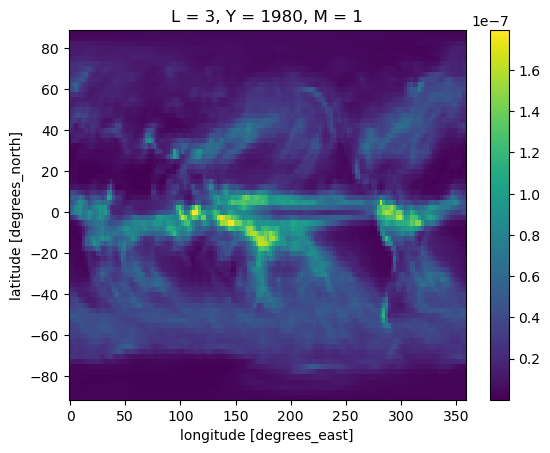

In [362]:
## Create regridder from CAM-FV1deg to destgrid
regrid_cam1deg = xe.Regridder(smyle11_seas, destgrid, 'conservative', periodic=True)
smyle11_da = regrid_cam1deg(smyle11_seas.PRECT)
smyle11_da.isel(Y=10,L=0,M=0).plot();

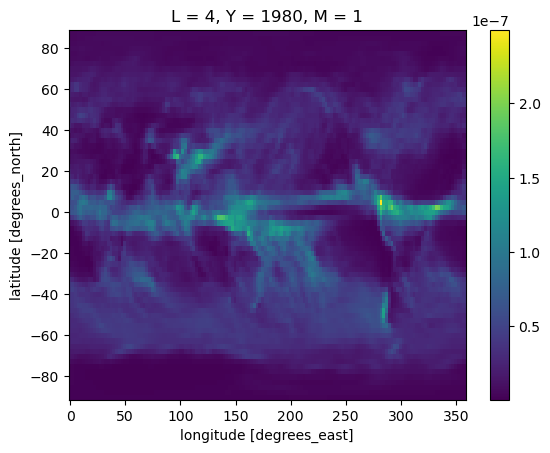

In [363]:
smyle11_da_high = regrid_cam1deg(smyle11_seas_high.PRECT)
smyle11_da_high.isel(Y=10,L=1,M=0).plot();

## Get precip OBS

In [245]:
# CRU TS4.05  (0.5deg PRE over land)
obs_dir = '/expanse/nfs/cw3e/csg100/_FROM_MEAD_2025.01.07/cesm/analysis/'
ds_cru = xr.open_dataset(obs_dir+'cru_ts4.05.1901.2020.pre.dat.nc',decode_times=False)
cru_montime_vals = [cftime.DatetimeNoLeap(1901+year, 1+month, 15) for year in range(120) for month in range(12)]
ds_cru['time'] = cru_montime_vals
ds_cru = ds_cru.sel(time=slice("1960","2019"))

In [246]:
# convert mm/month to m/s
convfact = xr.DataArray(1/((1.e3)*(ds_cru.time.dt.days_in_month.values*24*60*60)),dims=['time'],coords={'time':ds_cru.time})
ds_cru['pre'] = ds_cru['pre']*convfact.assign_attrs({'units':'m/s'})

In [247]:
# JRA55  (55-km global)
obs_dir = '/expanse/nfs/cw3e/csg100/_FROM_MEAD_2025.01.07/cesm/analysis/'
ds_jra55 = xr.open_dataset(obs_dir+'PRE_JRA55_1958-2019.nc')
nt = np.size(ds_jra55.time)
jra55_montime_vals = [cftime.DatetimeNoLeap(1958+year, 1+month, 15) for year in range(62) for month in range(12)]
ds_jra55['time'] = jra55_montime_vals
ds_jra55 = ds_jra55.sel(time=slice("1960","2019"))

In [248]:
# convert kg/m^2/s to m/s
convfact = xr.DataArray(1/(1.e3),dims=['time'],coords={'time':ds_jra55.time})
ds_jra55['pr'] = ds_jra55['pr']*convfact.assign_attrs({'units':'m/s'})

## Compute OBS seasonal averages

In [249]:
cru_seas = ds_cru.pre.rolling(time=3,min_periods=3, center=True).mean().dropna('time',how='all').rename('PRE')

In [250]:
jra55_seas = ds_jra55.pr.rolling(time=3,min_periods=3, center=True).mean().dropna('time',how='all').rename('PRE')

In [251]:
cru_seas = regrid.add_grid_bounds(cru_seas.to_dataset())
jra55_seas = regrid.add_grid_bounds(jra55_seas.to_dataset())

In [154]:
cru_seas

<xarray.Dataset>
Dimensions:     (lon: 720, lat: 360, time: 730, bounds: 2)
Coordinates:
  * lon         (lon) float32 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat         (lat) float32 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * time        (time) object 1960-02-15 00:00:00 ... 2020-11-15 00:00:00
    lon_bounds  (lon, bounds) float32 -180.0 -179.5 -179.5 ... 179.5 179.5 180.0
    lat_bounds  (lat, bounds) float32 -90.0 -89.5 -89.5 -89.0 ... 89.5 89.5 90.0
Dimensions without coordinates: bounds
Data variables:
    PRE         (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan

## Regrid & Merge PREP OBS

CPU times: user 5.73 s, sys: 306 ms, total: 6.03 s
Wall time: 6.05 s


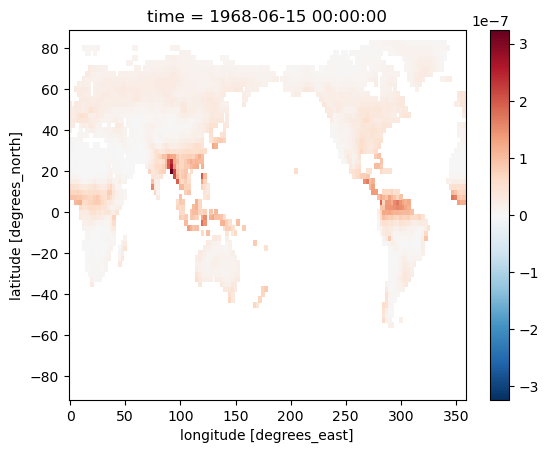

In [252]:
%%time
regrid_cru = xe.Regridder(cru_seas, destgrid, 'conservative', periodic=True)
cru_seas_rg = regrid_cru(cru_seas.PRE,skipna=True, na_thres=0.6)
cru_seas_rg.isel(time=100).plot()

CPU times: user 1.21 s, sys: 75.8 ms, total: 1.29 s
Wall time: 1.29 s


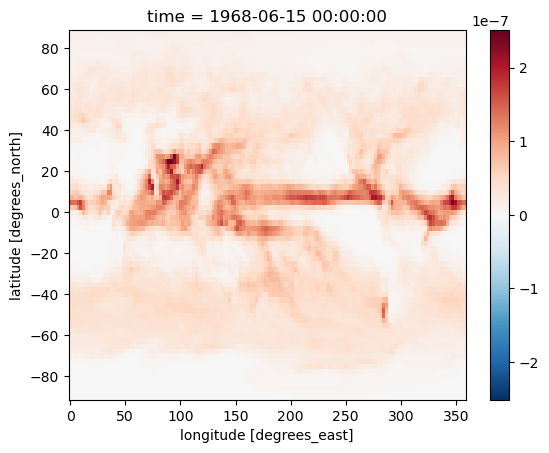

In [253]:
%%time
regrid_jra = xe.Regridder(jra55_seas, destgrid, 'conservative', periodic=True)
jra55_seas_rg = regrid_jra(jra55_seas.PRE,skipna=True, na_thres=0.9)
jra55_seas_rg.isel(time=100).plot()

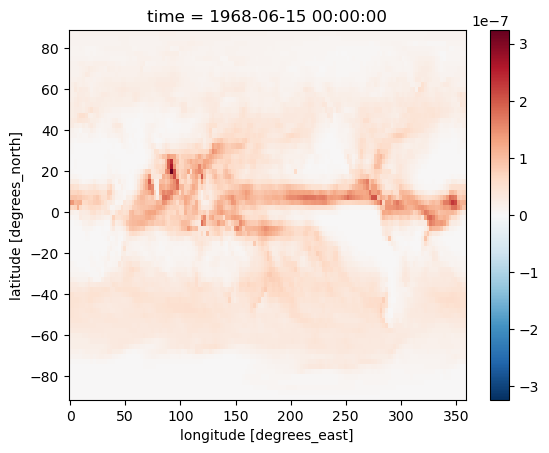

In [254]:
def merge_obs(da1,da2):
    return da1.fillna(da2)
cruhad = merge_obs(cru_seas_rg,jra55_seas_rg)
cruhad.isel(time=100).plot();

In [364]:
%%time
smyle11_time = smyle11_seas.time.load()
smyle11_time_high = smyle11_seas_high.time.load()

CPU times: user 192 µs, sys: 144 µs, total: 336 µs
Wall time: 350 µs


In [100]:
smyle11_time

<xarray.DataArray 'time' (Y: 50, L: 4)>
array([[cftime.DatetimeNoLeap(1971, 1, 15, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(1971, 2, 15, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(1971, 3, 15, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(1971, 4, 15, 0, 0, 0, 0, has_year_zero=True)],
       [cftime.DatetimeNoLeap(1972, 1, 15, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(1972, 2, 15, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(1972, 3, 15, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(1972, 4, 15, 0, 0, 0, 0, has_year_zero=True)],
       [cftime.DatetimeNoLeap(1973, 1, 15, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(1973, 2, 15, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(1973, 3, 15, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(1973, 4, 15, 0, 0, 0, 0, has_year_zero=True)],
       [cftime.DatetimeNoLeap(1974, 1, 15, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(1974, 2, 15, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(1974, 3, 15, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(1974, 4, 15, 0, 0, 0, 0, has_year_zero=True)],
       [cftime.DatetimeNoLeap(1975, 1, 15, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(1975, 2, 15, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(1975, 3, 15, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(1975, 4, 15, 0, 0, 0, 0, has_year_zero=True)],
...
        cftime.DatetimeNoLeap(2016, 2, 15, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(2016, 3, 15, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(2016, 4, 15, 0, 0, 0, 0, has_year_zero=True)],
       [cftime.DatetimeNoLeap(2017, 1, 15, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(2017, 2, 15, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(2017, 3, 15, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(2017, 4, 15, 0, 0, 0, 0, has_year_zero=True)],
       [cftime.DatetimeNoLeap(2018, 1, 15, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(2018, 2, 15, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(2018, 3, 15, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(2018, 4, 15, 0, 0, 0, 0, has_year_zero=True)],
       [cftime.DatetimeNoLeap(2019, 1, 15, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(2019, 2, 15, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(2019, 3, 15, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(2019, 4, 15, 0, 0, 0, 0, has_year_zero=True)],
       [cftime.DatetimeNoLeap(2020, 1, 15, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(2020, 2, 15, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(2020, 3, 15, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(2020, 4, 15, 0, 0, 0, 0, has_year_zero=True)]],
      dtype=object)
Coordinates:
  * L        (L) int64 3 4 5 6
  * Y        (Y) int64 1970 1971 1972 1973 1974 ... 2015 2016 2017 2018 2019

## Skill Analysis

In [365]:
%%time
# Compute de-drifted anomalies from specified climatology
climy0 = 1972
climy1 = 2017
smyle11_anom,smyle11_clim = stats.remove_drift(smyle11_da,smyle11_time,climy0,climy1)
smyle11_high_anom,smyle11_high_clim = stats.remove_drift(smyle11_da_high,smyle11_time_high,climy0,climy1)

CPU times: user 226 ms, sys: 13.5 ms, total: 239 ms
Wall time: 239 ms


In [257]:
def detrend_linear(dat, dim):
    """
    Linear detrend dat along the axis dim.
    Parameters
    ----------
    dat : array
        data which is to be detrended
    dim : str
        dimension along which linear detrending is performed
    Returns
    -------
    dat : DataArray
        detrended DataArray
    """

    # determine parameters
    params = dat.polyfit(dim=dim, deg=1)
    # determine fit
    fit = xr.polyval(dat[dim], params.polyfit_coefficients)
    # linearly detrend data
    dat = dat - fit

    return dat

In [366]:
%%time
smyle11_skill = stats.compute_skill_seasonal(smyle11_anom,smyle11_time,cruhad,str(climy0),str(climy1),1,4,resamp=0,detrend=True)
smyle11_high_skill = stats.compute_skill_seasonal(smyle11_high_anom,smyle11_time_high,cruhad,str(climy0),str(climy1),1,4,resamp=0,detrend=True)

CPU times: user 49.2 s, sys: 2min 17s, total: 3min 6s
Wall time: 6.86 s


In [24]:
smyle11_anom

<xarray.DataArray (Y: 50, L: 4, M: 20, lat: 180, lon: 360)>
array([[[[[ 8.34122549e-10,  8.37315994e-10,  8.36722691e-10, ...,
            8.44937897e-10,  8.41001047e-10,  8.35129743e-10],
          [ 9.64510249e-10,  1.00264996e-09,  9.93119809e-10, ...,
            1.05411746e-09,  1.01952047e-09,  9.72759873e-10],
          [ 4.96263031e-10,  5.85043125e-10,  5.43707301e-10, ...,
            5.29574606e-10,  4.96291452e-10,  4.84453144e-10],
          ...,
          [-1.17435883e-09, -1.16305499e-09, -1.15245324e-09, ...,
           -1.19415944e-09, -1.18910881e-09, -1.18256693e-09],
          [-1.01987130e-09, -1.01226849e-09, -1.00361452e-09, ...,
           -1.02490727e-09, -1.02351638e-09, -1.02270370e-09],
          [-9.55377555e-10, -9.51995816e-10, -9.48613632e-10, ...,
           -9.63989777e-10, -9.60470370e-10, -9.57650403e-10]],

         [[ 4.59983163e-11,  4.90278929e-11,  5.18731724e-11, ...,
            3.97579747e-11,  4.15782964e-11,  4.49813520e-11],
          [ 5.17437204e-10,  5.42954126e-10,  5.64031932e-10, ...,
            4.56347626e-10,  4.73959538e-10,  5.05438136e-10],
          [ 3.79381859e-10,  3.76518816e-10,  3.64773101e-10, ...,
            2.34202879e-10,  2.64468003e-10,  3.09984705e-10],
...
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan]],

         [[            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          ...,
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan]]]]],
      dtype=float32)
Coordinates:
  * L        (L) int64 3 4 5 6
  * Y        (Y) int64 1970 1971 1972 1973 1974 ... 2015 2016 2017 2018 2019
  * M        (M) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20
  * lat      (lat) int64 -90 -89 -88 -87 -86 -85 -84 ... 83 84 85 86 87 88 89
  * lon      (lon) int64 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359

In [58]:
smyle11_skill

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, L: 4)
Coordinates:
  * lat      (lat) int64 -90 -89 -88 -87 -86 -85 -84 ... 83 84 85 86 87 88 89
  * lon      (lon) int64 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
  * L        (L) int64 3 4 5 6
Data variables:
    corr     (L, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    pval     (L, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    rmse     (L, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    msss     (L, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    rpc      (L, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    sig_obs  (L, lat, lon) float64 3.905e-10 3.905e-10 ... 1.357e-09 1.356e-09
    sig_sig  (L, lat, lon) float64 1.932e-10 1.927e-10 1.925e-10 ... nan nan nan
    sig_tot  (L, lat, lon) float64 7.668e-10 7.688e-10 7.696e-10 ... nan nan nan
    s2t      (L, lat, lon) float64 0.2519 0.2507 0.2502 0.25 ... nan nan nan nan

In [367]:
smyle11_anom_L1=smyle11_anom.isel(L=0)

In [368]:
smyle11_high_anom_L1=smyle11_high_anom.isel(L=0)

In [369]:
smyle11_time_L1=smyle11_time.isel(L=0)

In [370]:
smyle11_time_L1

<xarray.DataArray 'time' (Y: 50)>
array([cftime.DatetimeNoLeap(1970, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1971, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1972, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1973, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1974, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1975, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1976, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1977, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1978, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1979, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1980, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1981, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1982, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1983, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1984, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1985, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1986, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1987, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1988, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1989, 4, 15, 0, 0, 0, 0, has_year_zero=True),
...
       cftime.DatetimeNoLeap(2001, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2002, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2003, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2004, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2005, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2006, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2007, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2008, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2009, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2010, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2011, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2012, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2013, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2014, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2016, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2017, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2018, 4, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2019, 4, 15, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
    L        int64 3
  * Y        (Y) int64 1970 1971 1972 1973 1974 ... 2015 2016 2017 2018 2019

In [371]:
M_smyle_seas=smyle11_anom_L1.transpose('M',...)
M_smyle_seas_high=smyle11_high_anom_L1.transpose('M',...)

In [118]:
M_smyle_seas

<xarray.DataArray (M: 20, Y: 50, lat: 180, lon: 360)>
array([[[[ 8.34122549e-10,  8.37315994e-10,  8.36722691e-10, ...,
           8.44937897e-10,  8.41001047e-10,  8.35129743e-10],
         [ 9.64510249e-10,  1.00264996e-09,  9.93119809e-10, ...,
           1.05411746e-09,  1.01952047e-09,  9.72759873e-10],
         [ 4.96263031e-10,  5.85043125e-10,  5.43707301e-10, ...,
           5.29574606e-10,  4.96291452e-10,  4.84453144e-10],
         ...,
         [-1.17435883e-09, -1.16305499e-09, -1.15245324e-09, ...,
          -1.19415944e-09, -1.18910881e-09, -1.18256693e-09],
         [-1.01987130e-09, -1.01226849e-09, -1.00361452e-09, ...,
          -1.02490727e-09, -1.02351638e-09, -1.02270370e-09],
         [-9.55377555e-10, -9.51995816e-10, -9.48613632e-10, ...,
          -9.63989777e-10, -9.60470370e-10, -9.57650403e-10]],

        [[-3.24423155e-10, -3.21258575e-10, -3.18693072e-10, ...,
          -3.29842376e-10, -3.29198890e-10, -3.28133076e-10],
         [-1.14379839e-10, -6.17923490e-11, -4.91660046e-11, ...,
          -1.92604377e-10, -1.74227299e-10, -1.47828638e-10],
         [-1.02136966e-10,  1.72927006e-10,  1.32951428e-10, ...,
          -2.59987809e-10, -2.10401696e-10, -1.53564716e-10],
...
          -5.71258596e-10, -5.73590508e-10, -5.75759440e-10],
         [-2.41947795e-10, -2.24494645e-10, -2.07423412e-10, ...,
          -2.78820078e-10, -2.69359202e-10, -2.58081112e-10],
         [ 2.89638535e-10,  2.86577873e-10,  2.81819901e-10, ...,
           2.90828694e-10,  2.89665181e-10,  2.90108382e-10]],

        [[-8.90773677e-10, -8.97941055e-10, -9.01434483e-10, ...,
          -8.85850282e-10, -8.86488216e-10, -8.89311957e-10],
         [-5.48572743e-10, -5.77967230e-10, -6.26156016e-10, ...,
          -5.32882183e-10, -5.33165068e-10, -5.49219781e-10],
         [-4.43737491e-10, -2.61873190e-10, -4.19550616e-10, ...,
          -7.67832020e-10, -7.24352134e-10, -6.54955645e-10],
         ...,
         [ 2.87751956e-09,  2.87269097e-09,  2.86530089e-09, ...,
           2.86350943e-09,  2.87364754e-09,  2.87836910e-09],
         [ 1.55936464e-09,  1.55213042e-09,  1.54228186e-09, ...,
           1.57131330e-09,  1.56902358e-09,  1.56582258e-09],
         [ 7.99841970e-10,  7.95324251e-10,  7.89131871e-10, ...,
           8.02159228e-10,  8.04218914e-10,  8.05641331e-10]]]],
      dtype=float32)
Coordinates:
    L        int64 3
  * Y        (Y) int64 1970 1971 1972 1973 1974 ... 2015 2016 2017 2018 2019
  * M        (M) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20
  * lat      (lat) int64 -90 -89 -88 -87 -86 -85 -84 ... 83 84 85 86 87 88 89
  * lon      (lon) int64 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359

In [372]:
from SMYLEutils import bootstrap_utils as boot
boot_M_smyle = []
boot_M_smyle_high = []
for iyear in np.arange(0,M_smyle_seas.Y.size,1):
    print(iyear)
    boot_M_smyle_seas=boot.bootgen(M_smyle_seas.isel(Y=iyear),nboots=10)
    boot_M_smyle.append(boot_M_smyle_seas)
boot_M_smyle = xr.concat(boot_M_smyle, dim=M_smyle_seas.Y)

0
you are using an xarray dataarray
1
you are using an xarray dataarray
2
you are using an xarray dataarray
3
you are using an xarray dataarray
4
you are using an xarray dataarray
5
you are using an xarray dataarray
6
you are using an xarray dataarray
7
you are using an xarray dataarray
8
you are using an xarray dataarray
9
you are using an xarray dataarray
10
you are using an xarray dataarray
11
you are using an xarray dataarray
12
you are using an xarray dataarray
13
you are using an xarray dataarray
14
you are using an xarray dataarray
15
you are using an xarray dataarray
16
you are using an xarray dataarray
17
you are using an xarray dataarray
18
you are using an xarray dataarray
19
you are using an xarray dataarray
20
you are using an xarray dataarray
21
you are using an xarray dataarray
22
you are using an xarray dataarray
23
you are using an xarray dataarray
24
you are using an xarray dataarray
25
you are using an xarray dataarray
26
you are using an xarray dataarray
27
you are 

In [373]:
for iyear in np.arange(0,M_smyle_seas.Y.size,1):
    print(iyear)
    boot_M_smyle_seas_high=boot.bootgen(M_smyle_seas_high.isel(Y=iyear),nboots=10)
    boot_M_smyle_high.append(boot_M_smyle_seas_high)
boot_M_smyle_high = xr.concat(boot_M_smyle_high, dim=M_smyle_seas.Y)

0
you are using an xarray dataarray
1
you are using an xarray dataarray
2
you are using an xarray dataarray
3
you are using an xarray dataarray
4
you are using an xarray dataarray
5
you are using an xarray dataarray
6
you are using an xarray dataarray
7
you are using an xarray dataarray
8
you are using an xarray dataarray
9
you are using an xarray dataarray
10
you are using an xarray dataarray
11
you are using an xarray dataarray
12
you are using an xarray dataarray
13
you are using an xarray dataarray
14
you are using an xarray dataarray
15
you are using an xarray dataarray
16
you are using an xarray dataarray
17
you are using an xarray dataarray
18
you are using an xarray dataarray
19
you are using an xarray dataarray
20
you are using an xarray dataarray
21
you are using an xarray dataarray
22
you are using an xarray dataarray
23
you are using an xarray dataarray
24
you are using an xarray dataarray
25
you are using an xarray dataarray
26
you are using an xarray dataarray
27
you are 

In [29]:
boot_M_smyle_high

<xarray.DataArray (Y: 50, iboot: 1000, isample: 20, lat: 72, lon: 144)>
array([[[[[-2.77210255e-10, -2.52499799e-10, -2.45635068e-10, ...,
           -2.73354894e-10, -2.88219670e-10, -2.96246361e-10],
          [-1.66912928e-10, -2.41589859e-10, -2.81038748e-10, ...,
            1.49118717e-10,  9.68545244e-11,  1.21715971e-11],
          [ 1.79204207e-10,  2.74837930e-11, -2.06510364e-11, ...,
            6.76260381e-10,  6.12669693e-10,  4.10657286e-10],
          ...,
          [ 1.73996995e-09,  1.80777437e-09,  1.59274283e-09, ...,
            1.20410437e-09,  1.25065380e-09,  1.49026569e-09],
          [ 4.67082817e-10,  2.25147012e-10, -2.62887490e-11, ...,
            7.99028843e-10,  7.85393972e-10,  6.99616365e-10],
          [ 8.19895707e-10,  7.16879889e-10,  6.17458973e-10, ...,
            1.06053477e-09,  9.85890924e-10,  9.06097863e-10]],

         [[ 6.50809184e-10,  7.80146614e-10,  8.26194224e-10, ...,
            5.33033395e-10,  5.76062087e-10,  6.20729912e-10],
          [ 4.05579570e-10,  4.73611372e-10,  5.48068702e-10, ...,
            4.12510914e-10,  3.77656795e-10,  3.27466054e-10],
          [ 1.72329262e-10,  4.76716888e-10,  2.76243473e-10, ...,
           -1.15113474e-10, -9.69087033e-11, -3.01032532e-11],
...
            1.47899915e-09,  1.27772726e-09,  8.68443983e-10],
          [ 2.42147058e-09,  2.22745111e-09,  2.03808170e-09, ...,
            2.79655898e-09,  2.75933143e-09,  2.63144528e-09],
          [ 1.72698655e-09,  1.71209624e-09,  1.70888459e-09, ...,
            1.88382332e-09,  1.83347781e-09,  1.77230719e-09]],

         [[-5.09028375e-11,  2.81374923e-12,  2.58033594e-11, ...,
           -6.18585183e-11, -4.12343493e-11, -4.25728341e-11],
          [ 4.54063454e-11,  4.80384621e-11,  1.27764022e-10, ...,
            2.63529198e-10,  2.16890950e-10,  1.36296530e-10],
          [-1.24828148e-10, -3.35296235e-11,  8.17479417e-11, ...,
            1.28076438e-10,  1.16124887e-10, -1.45972123e-12],
          ...,
          [ 5.15652410e-10,  4.77312412e-10,  2.86082269e-10, ...,
            5.12209830e-10,  4.09535517e-10,  4.66791938e-10],
          [-4.44965398e-10, -4.69921879e-10, -5.34654099e-10, ...,
           -6.61375843e-10, -5.46742651e-10, -4.92616170e-10],
          [ 4.23591828e-10,  4.27041069e-10,  4.26892299e-10, ...,
            3.48878260e-10,  3.92923027e-10,  4.09770884e-10]]]]],
      dtype=float32)
Coordinates:
  * iboot    (iboot) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
  * isample  (isample) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
  * lat      (lat) float64 -90.0 -87.5 -85.0 -82.5 -80.0 ... 80.0 82.5 85.0 87.5
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * Y        (Y) int64 1970 1971 1972 1973 1974 ... 2015 2016 2017 2018 2019

In [374]:
boot_M_smyle = boot_M_smyle.transpose('iboot','Y','isample','lat','lon')
boot_M_smyle = boot_M_smyle.rename({'iboot':'ibootmem'}) # renaming the bootstrap dim
boot_M_smyle = boot_M_smyle.rename({'isample':'M'}) # renaming the member dim

boot_M_smyle_high = boot_M_smyle_high.transpose('iboot','Y','isample','lat','lon')
boot_M_smyle_high = boot_M_smyle_high.rename({'iboot':'ibootmem'}) # renaming the bootstrap dim
boot_M_smyle_high = boot_M_smyle_high.rename({'isample':'M'}) # renaming the member dim

In [375]:
bootstrap=10
def patterncc_bootstrap(bootall,smyledata,smyletime,bootstrap):
    model_temp=[]
    model_time=[]
    #model_temp=np.empty( ( bootstrap,50,4,20) ,dtype=float)
    for inumber in range (len(bootall)):
       # n=0
       # model_temp[:,inumber*n,:,:]=smyledata[ :,boot[inumber], :, : ]
       # model_temp[:,inumber*n+1,:,:]=smyledata[ :,boot[inumber]+1, :, : ]
       # model_temp[:,inumber*n+2,:,:]=smyledata[ :,boot[inumber]+2, :, : ]
       # model_temp[:,inumber*n+3,:,:]=smyledata[ :,boot[inumber]+3, :, : ]
       # model_temp[:,inumber*n+4,:,:]=smyledata[ :,boot[inumber]+4, :, : ]
        model_temp.append(smyledata[ :,bootall[inumber]:bootall[inumber]+5, :, :,: ])
        model_time.append(smyletime[bootall[inumber]:bootall[inumber]+5])
       # n=n+5
    return model_temp,model_time

In [376]:
import xskillscore as xs
def compute_skill_seasonal(mod_da,mod_time,obs_da,climy0,climy1,detrend=False):
    #corr_list = []
    obs_da=obs_da.sel(time=slice("1970","2020"))
    obs_seas_more=[]
    ens_ts = mod_da.rename({'Y':'time'})
    ens_time_year = mod_time.dt.year
    ens_time_month = mod_time.dt.month.data[0]
    ens_ts = ens_ts.assign_coords(time=("time",ens_time_year.data))
    obsisel = obs_da.time.dt.month==ens_time_month
    obs_seas = obs_da.isel(time=obsisel)
    year_to_select=ens_time_year
    for inumber in range (len(year_to_select)):
        obs_seas_more.append(obs_seas.sel(time=obs_seas.time.dt.year==year_to_select[inumber]))
    obs_seas_more_all=xr.concat(obs_seas_more, dim='time')
    obs_seas_more_all = obs_seas_more_all.assign_coords(time=("time",ens_time_year.data))
    amean = ens_ts.mean('M')
    r = xr.corr(amean,obs_seas_more_all,dim='time')
    #corr_list.append(r)
    #corr = xr.concat(corr_list)
    return r

In [377]:
allboots_boot_time_smyle11_skill_st=[]
allboots_boot_time_smyle11_skill_high_st=[]
for iboot in np.arange(0,boot_M_smyle.ibootmem.size,1):
#for iboot in np.arange(0,5,1):
    rng = np.random.default_rng()
    random_numbers = rng.choice ( 46,10)
    bootall=random_numbers
    boot_M_stnao_smyle11_seas_time, boot_smyle11_time= patterncc_bootstrap(bootall,boot_M_smyle,smyle11_time_L1,bootstrap)
    boot_M_stnao_smyle11_seas_time_high, boot_smyle11_time_high= patterncc_bootstrap(bootall,boot_M_smyle_high,smyle11_time_L1,bootstrap)
    allboot_M_stnao_smyle11_seas_time=xr.concat(boot_M_stnao_smyle11_seas_time, dim='Y')
    allboot_M_stnao_smyle11_seas_time_high=xr.concat(boot_M_stnao_smyle11_seas_time_high, dim='Y')
    
    allboot_smyle11_time=xr.concat(boot_smyle11_time, dim='Y')
    allboot_smyle11_time_high=xr.concat(boot_smyle11_time_high, dim='Y')
    
    boot_smyle11_skill_st_time= compute_skill_seasonal(allboot_M_stnao_smyle11_seas_time.isel(ibootmem=iboot),allboot_smyle11_time,cruhad,str(climy0),str(climy1),detrend=True)
    allboots_boot_time_smyle11_skill_st.append(boot_smyle11_skill_st_time)
    boot_smyle11_skill_st_time_high= compute_skill_seasonal(allboot_M_stnao_smyle11_seas_time_high.isel(ibootmem=iboot),allboot_smyle11_time_high,cruhad,str(climy0),str(climy1),detrend=True)
    allboots_boot_time_smyle11_skill_high_st.append(boot_smyle11_skill_st_time_high)

In [378]:
allboots_boot_M_smyle11_skill_st = xr.concat(allboots_boot_time_smyle11_skill_st, dim='iboot')
allboots_boot_M_smyle11_skill_st_high = xr.concat(allboots_boot_time_smyle11_skill_high_st, dim='iboot')

In [379]:
min95_boot_M_smyle11_skill = allboots_boot_M_smyle11_skill_st.quantile(0.025, dim='iboot') 
max95_boot_M_smyle11_skill = allboots_boot_M_smyle11_skill_st.quantile(0.975, dim='iboot')

min95_boot_M_smyle11_skill_high = allboots_boot_M_smyle11_skill_st_high.quantile(0.025, dim='iboot') 
max95_boot_M_smyle11_skill_high = allboots_boot_M_smyle11_skill_st_high.quantile(0.975, dim='iboot')

In [380]:
smyle11_skill['corr'] = smyle11_skill.corr.where(((min95_boot_M_smyle11_skill > 0) & (max95_boot_M_smyle11_skill > 0)) | ((min95_boot_M_smyle11_skill < 0) & (max95_boot_M_smyle11_skill < 0)))

In [381]:
smyle11_high_skill['corr'] = smyle11_high_skill.corr.where(((min95_boot_M_smyle11_skill_high > 0) & (max95_boot_M_smyle11_skill_high > 0)) | ((min95_boot_M_smyle11_skill_high < 0) & (max95_boot_M_smyle11_skill_high < 0)))

In [37]:
###### Do not run  ##############

# Zero out ACC where insignificant
siglvl = 0.1
smyle11_skill['corr'] = smyle11_skill.corr.where(smyle11_skill.pval<siglvl)
smyle11_high_skill['corr'] = smyle11_high_skill.corr.where(smyle11_high_skill.pval<siglvl)

In [321]:
import matplotlib.pyplot as plt
import cartopy
import numpy as np
from SMYLEutils import colormap_utils as mycolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.ticker as mticker
from matplotlib.colors import BoundaryNorm

In [216]:
def map_pcolor_global_subplot(fig, dat, lon, lat, ci, cmin, cmax, titlestr,
                              nrow,ncol,subplot, proj, labels=True, showland=True, 
                              grid="latlon", cmap="blue2red", facecolor="white",
                              fontsize=15,centrallon=0,tricontour=False,cutoff=0.5):
    """ plot a contour map of 2D data dat with coordinates lon and lat
        Input:
              fig = the figure identifier
              dat = the data to be plotted
              lon = the longitude coordinate
              lat = the latitude coordinate
              ci = the contour interval:
              cmin = the minimum of the contour range
              cmax = the maximum of the contour range
              titlestr = the title of the map
              nrow = number of rows in multipanel plot
              ncol = number of columns in multipanel plot
              subplot = subplot number
              proj = cartopy map projection to use
              labels = True/False (ticks and  labels are plotted if true) 
              showland = True/False (if False, fill over land)
              grid = ('latlon','camfv','camse','pop')
              cmap = color map (only set up for blue2red at the moment)
    """

    # set up contour levels and color map
    nlevs = (cmax-cmin)/ci + 1
    clevs = np.arange(cmin, cmax+ci, ci)

    if (cmap == "blue2red"):
        cmap = mycolors.blue2red_cmap(nlevs)
        #mymap.set_over('pink')
        #mymap.set_under('cyan')
    elif (cmap == "precip"):
        cmap = mycolors.precip_cmap(nlevs)
    elif (cmap == "blue2red_acc"):
        cmap = mycolors.blue2red_acc_cmap(clevs,cutoff)
    else:
        cmap = mpl.cm.get_cmap(cmap)
    
    norm = BoundaryNorm(clevs, ncolors=cmap.N, clip=True)
    ax = fig.add_subplot(nrow,ncol,subplot, projection=proj)
    ax.set_aspect('auto')
    ax.set_title(titlestr, fontsize=fontsize)
    ax.set_facecolor(facecolor)
    if showland:
        ax.add_feature(cfeature.COASTLINE)
    else:
        ax.add_feature(cfeature.LAND, edgecolor='black',linewidth=0.1, facecolor='grey', zorder=1)
  
    if grid=="latlon" or grid=="camfv":
        dat, lon = add_cyclic_point(dat, coord=lon)
        cntr = ax.pcolormesh(lon, lat, dat, shading='nearest',vmin=clevs.min(),vmax=clevs.max(),  cmap = cmap, norm=norm, rasterized=True, transform=ccrs.PlateCarree())
        
    elif grid=="camse":
        tri, z = get_refined_triang(lon,lat, dat)
        cntr = ax.tripcolor(tri, z, shading='flat',vmin=clevs.min(),vmax=clevs.max(), cmap = cmap, norm=norm,  rasterized=True, transform=ccrs.PlateCarree())
        
    elif grid=="pop":
        lon, lat, dat = adjust_pop_grid(lon, lat, dat)
        cntr = ax.pcolormesh(lon, lat, dat, shading='nearest',vmin=clevs.min(),vmax=clevs.max(), cmap = cmap, norm=norm, rasterized=True, transform=ccrs.PlateCarree())
        
    else:
        raise ValueError('ERROR: unknown grid')
        
#    ax.set_global()
    return ax,cntr

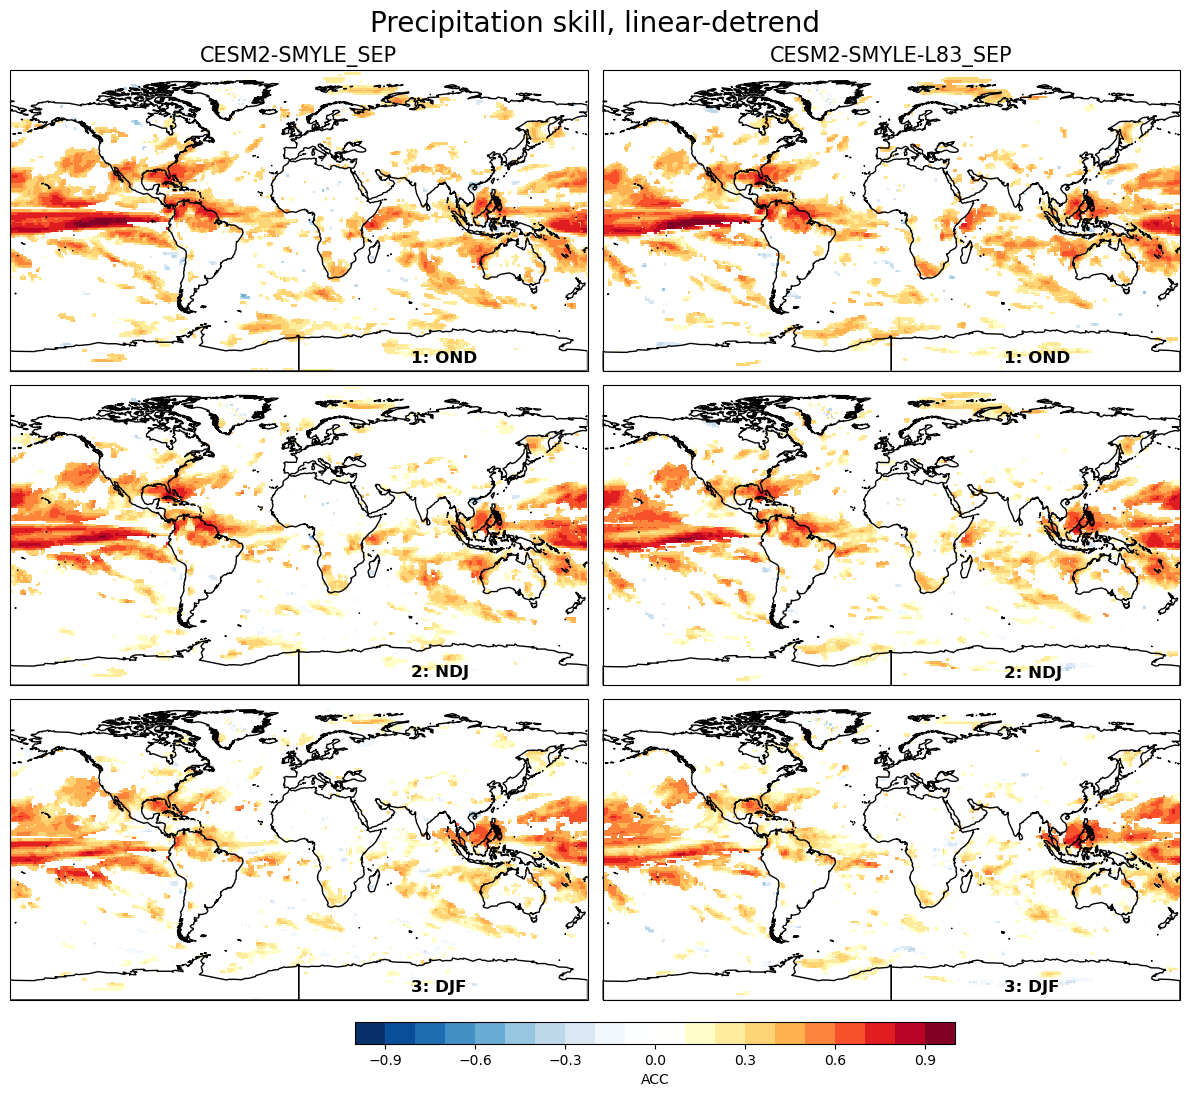

In [222]:
ci = 0.1
cmin = -1
cmax = 1
hatchlevs = [0,0.1,100]
fig = plt.figure(figsize=(12,11))
nrows=3
ncols=2

proj = ccrs.PlateCarree()
#proj = ccrs.Robinson(central_longitude=0)
colstr = ['CESM2-SMYLE_SEP_low top','CESM2-SMYLE_SEP_high top']
ltime = ['1','2','3']
seas11dict = {1:'OND',2:'NDJ',3:'DJF'}
lstr = ''
rstr = ''
fsize=12
fweight='bold'
cmap = "precip"
coff = 0.5
siglvl = 0.1
nlevs = (cmax-cmin)/ci + 1
clevs = np.arange(cmin, cmax+ci, ci)
#cmap = mycolors.blue2red_acc_cmap(clevs,0.5)
cmap = mycolors.blue2red_cmap(nlevs)
norm = BoundaryNorm(clevs, ncolors=cmap.N, clip=True)


ax1 = fig.add_subplot(nrows,ncols,1, projection=proj)
ax1.set_aspect('auto')
#ax1.coastlines(resolution='10m')
ax1.add_feature(cartopy.feature.GSHHSFeature(edgecolor='k'))
ax1.set_title('CESM2-SMYLE_SEP', fontsize=15)
ax1.set_facecolor("white")
dat, lon = add_cyclic_point(smyle11_skill.corr.isel(L=0), coord=smyle11_skill.lon)
cntr1 = ax1.pcolormesh(smyle11_skill.lon, smyle11_skill.lat, smyle11_skill.corr.isel(L=0), shading='nearest',vmin=clevs.min(),vmax=clevs.max(),  cmap = cmap, norm=norm, rasterized=True, transform=ccrs.PlateCarree())
ldstr = '1: ' + seas11dict[1]
ax1.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    
ax2 = fig.add_subplot(nrows,ncols,3, projection=proj)
ax2.set_aspect('auto')
ax2.add_feature(cartopy.feature.GSHHSFeature(edgecolor='k'))
ax2.set_title('', fontsize=15)
ax2.set_facecolor("white")
dat, lon = add_cyclic_point(smyle11_skill.corr.isel(L=1), coord=smyle11_skill.lon)
cntr2 = ax2.pcolormesh(smyle11_skill.lon, smyle11_skill.lat, smyle11_skill.corr.isel(L=1), shading='nearest',vmin=clevs.min(),vmax=clevs.max(),  cmap = cmap, norm=norm, rasterized=True, transform=ccrs.PlateCarree())
ldstr = '2: ' + seas11dict[2]
ax2.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)

ax3 = fig.add_subplot(nrows,ncols,5, projection=proj)
ax3.set_aspect('auto')
ax3.add_feature(cartopy.feature.GSHHSFeature(edgecolor='k'))
ax3.set_title('', fontsize=15)
ax3.set_facecolor("white")
dat, lon = add_cyclic_point(smyle11_skill.corr.isel(L=2), coord=smyle11_skill.lon)
cntr3 = ax3.pcolormesh(smyle11_skill.lon, smyle11_skill.lat, smyle11_skill.corr.isel(L=2), shading='nearest',vmin=clevs.min(),vmax=clevs.max(),  cmap = cmap, norm=norm, rasterized=True, transform=ccrs.PlateCarree())
ldstr = '3: ' + seas11dict[3]
ax3.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)

ax1 = fig.add_subplot(nrows,ncols,2, projection=proj)
ax1.set_aspect('auto')
#ax1.coastlines(resolution='10m')
ax1.add_feature(cartopy.feature.GSHHSFeature(edgecolor='k'))
ax1.set_title('CESM2-SMYLE-L83_SEP', fontsize=15)
ax1.set_facecolor("white")
dat, lon = add_cyclic_point(smyle11_high_skill.corr.isel(L=0), coord=smyle11_high_skill.lon)
cntr1 = ax1.pcolormesh(smyle11_high_skill.lon, smyle11_high_skill.lat, smyle11_high_skill.corr.isel(L=0), shading='nearest',vmin=clevs.min(),vmax=clevs.max(),  cmap = cmap, norm=norm, rasterized=True, transform=ccrs.PlateCarree())
ldstr = '1: ' + seas11dict[1]
ax1.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    
ax2 = fig.add_subplot(nrows,ncols,4, projection=proj)
ax2.set_aspect('auto')
ax2.add_feature(cartopy.feature.GSHHSFeature(edgecolor='k'))
ax2.set_title('', fontsize=15)
ax2.set_facecolor("white")
dat, lon = add_cyclic_point(smyle11_high_skill.corr.isel(L=1), coord=smyle11_high_skill.lon)
cntr2 = ax2.pcolormesh(smyle11_high_skill.lon, smyle11_high_skill.lat, smyle11_high_skill.corr.isel(L=1), shading='nearest',vmin=clevs.min(),vmax=clevs.max(),  cmap = cmap, norm=norm, rasterized=True, transform=ccrs.PlateCarree())
ldstr = '2: ' + seas11dict[2]
ax2.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)

ax3 = fig.add_subplot(nrows,ncols,6, projection=proj)
ax3.set_aspect('auto')
ax3.add_feature(cartopy.feature.GSHHSFeature(edgecolor='k'))
ax3.set_title('', fontsize=15)
ax3.set_facecolor("white")
dat, lon = add_cyclic_point(smyle11_high_skill.corr.isel(L=2), coord=smyle11_high_skill.lon)
cntr3 = ax3.pcolormesh(smyle11_high_skill.lon, smyle11_high_skill.lat, smyle11_high_skill.corr.isel(L=2), shading='nearest',vmin=clevs.min(),vmax=clevs.max(),  cmap = cmap, norm=norm, rasterized=True, transform=ccrs.PlateCarree())
ldstr = '3: ' + seas11dict[3]
ax3.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)

fig.suptitle('Precipitation skill, linear-detrend',fontsize=20)
fig.tight_layout()
fig.subplots_adjust(bottom=0.08)
cbar_ax = fig.add_axes([0.3, 0.04, 0.5, 0.02])
fig.colorbar(cntr1, cax=cbar_ax, label='ACC', orientation='horizontal')
#plt.savefig('PREC_ACC_lineardetrend_comparison_SEP_low vs high_new_bootstrap.pdf')

## Test difference of SMYLE11-low vs SMYLE11-high

In [382]:
smyle11_skilldiff = smyle11_high_skill - smyle11_skill
boot_diff = allboots_boot_M_smyle11_skill_st_high - allboots_boot_M_smyle11_skill_st

In [383]:
import warnings
warnings.filterwarnings("ignore") # Ignores all warnings

min95_boot_M_smyle11_diff = boot_diff.quantile(0.025, dim='iboot') 
max95_boot_M_smyle11_diff = boot_diff.quantile(0.975, dim='iboot')

In [384]:
smyle11_skilldiff['corr'] = smyle11_skilldiff.corr.where(((max95_boot_M_smyle11_diff > 0.0) & (min95_boot_M_smyle11_diff > 0.0)) | ((max95_boot_M_smyle11_diff < 0) & (min95_boot_M_smyle11_diff < 0)))

In [44]:
#smyle11_skilldiff['corr'] = smyle11_skilldiff.corr.where(((min95_skilldiff.corr > 0) & (max95_skilldiff.corr > 0)) | ((min95_skilldiff.corr < 0) & (max95_skilldiff.corr < 0)))

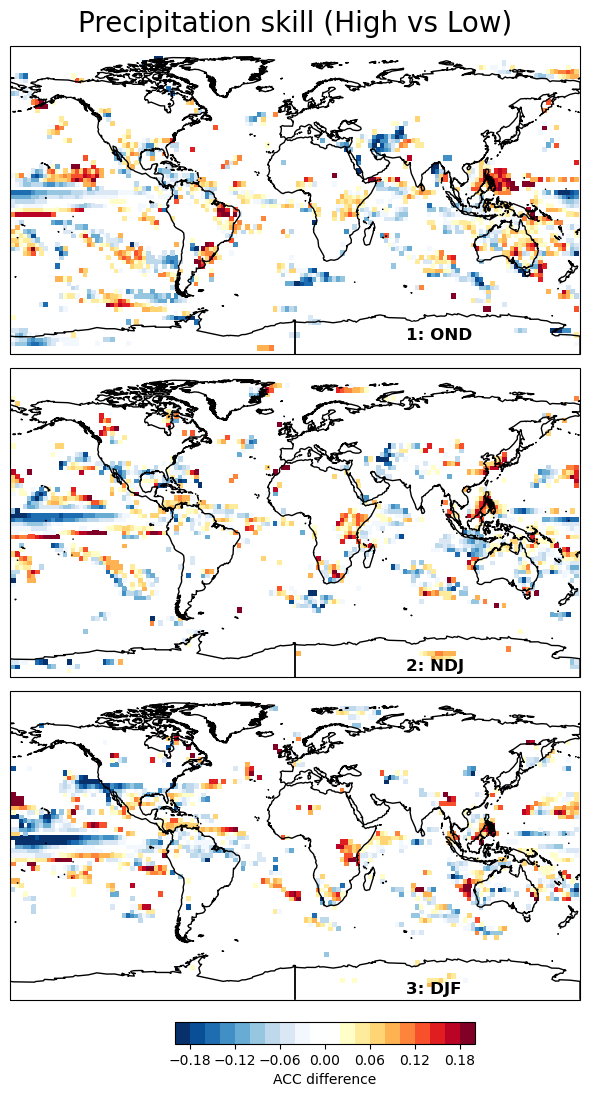

In [45]:
ci = 0.02
cmin = -0.2
cmax = 0.2
hatchlevs = [0,0.1,100]
fig = plt.figure(figsize=(6,11))
nrows=3
ncols=1
latlim = 80

symclr = 'black'

proj = ccrs.PlateCarree()
#proj = ccrs.Robinson(central_longitude=0)
colstr = ['CESM2-SMYLE_SEP_difference']
ltime = ['1','2','3']
seas11dict = {1:'OND',2:'NDJ',3:'DJF'}
lstr = ''
rstr = ''
fsize=12
fweight='bold'
cmap = "blue2red"
coff = 0.5
siglvl = 0.1
nlevs = (cmax-cmin)/ci + 1
clevs = np.arange(cmin, cmax+ci, ci)
cmap = mycolors.blue2red_cmap(nlevs)
norm = BoundaryNorm(clevs, ncolors=cmap.N, clip=True)


ax1 = fig.add_subplot(nrows,ncols,1, projection=proj)
ax1.set_aspect('auto')
#ax1.coastlines(resolution='10m')
ax1.add_feature(cartopy.feature.GSHHSFeature(edgecolor='k'))
ax1.set_title('', fontsize=15)
ax1.set_facecolor("white")
dat, lon = add_cyclic_point(smyle11_skilldiff.corr.isel(L=0), coord=smyle11_skill.lon)
cntr1 = ax1.pcolormesh(smyle11_skill.lon, smyle11_skill.lat, smyle11_skilldiff.corr.isel(L=0), shading='nearest',vmin=clevs.min(),vmax=clevs.max(),  cmap = cmap, norm=norm, rasterized=True, transform=ccrs.PlateCarree())
ldstr = '1: ' + seas11dict[1]
ax1.text(70.,-80,ldstr,fontsize=fsize,fontweight=fweight,backgroundcolor='white',zorder=10)
#tmp = xr.where(~smyle11_skill.corr.isel(L=0).isnull(),accpval.isel(L=0),np.nan)
#tmplon = np.where(tmp<siglvl,lon2d,np.nan); tmplon = np.where(abs(lat2d)<latlim,tmplon,np.nan)
#tmplat = np.where(tmp<siglvl,lat2d,np.nan); tmplat = np.where(abs(lat2d)<latlim,tmplat,np.nan)
#tmparea = np.where(tmp<siglvl,destgrid.area,0); tmparea = np.where(abs(lat2d)<latlim,tmparea,0)
#nbetter = np.sum(tmparea)/np.sum(np.where(abs(lat2d)<latlim,destgrid.area,0))
##ax1.scatter(tmplon,tmplat,facecolor='none', edgecolor=symclr,s=10,zorder=10)
#tmplon = np.where(tmp>(1-siglvl),lon2d,np.nan); tmplon = np.where(abs(lat2d)<latlim,tmplon,np.nan)
#tmplat = np.where(tmp>(1-siglvl),lat2d,np.nan); tmplat = np.where(abs(lat2d)<latlim,tmplat,np.nan)
#tmparea = np.where(tmp>(1-siglvl),destgrid.area,0); tmparea = np.where(abs(lat2d)<latlim,tmparea,0)
#nworse = np.sum(tmparea)/np.sum(np.where(abs(lat2d)<latlim,destgrid.area,0))
##ax1.scatter(tmplon,tmplat,facecolor=symclr, edgecolor=symclr,s=3,zorder=10)
#ax1.text(60.,-81,"({0:3.1f}%/{1:3.1f}%)".format(nbetter*100,nworse*100),fontsize=fsize,backgroundcolor='white',zorder=10)
    
ax2 = fig.add_subplot(nrows,ncols,2, projection=proj)
ax2.set_aspect('auto')
ax2.add_feature(cartopy.feature.GSHHSFeature(edgecolor='k'))
ax2.set_title('', fontsize=15)
ax2.set_facecolor("white")
dat, lon = add_cyclic_point(smyle11_skilldiff.corr.isel(L=1), coord=smyle11_skill.lon)
cntr2 = ax2.pcolormesh(smyle11_skill.lon, smyle11_skill.lat, smyle11_skilldiff.corr.isel(L=1), shading='nearest',vmin=clevs.min(),vmax=clevs.max(),  cmap = cmap, norm=norm, rasterized=True, transform=ccrs.PlateCarree())
ldstr = '2: ' + seas11dict[2]
ax2.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
#tmp = xr.where(~smyle11_skill.corr.isel(L=1).isnull(),accpval.isel(L=1),np.nan)
#tmplon = np.where(tmp<siglvl,lon2d,np.nan); tmplon = np.where(abs(lat2d)<latlim,tmplon,np.nan)
#tmplat = np.where(tmp<siglvl,lat2d,np.nan); tmplat = np.where(abs(lat2d)<latlim,tmplat,np.nan)
#tmparea = np.where(tmp<siglvl,destgrid.area,0); tmparea = np.where(abs(lat2d)<latlim,tmparea,0)
#nbetter = np.sum(tmparea)/np.sum(np.where(abs(lat2d)<latlim,destgrid.area,0))
##ax2.scatter(tmplon,tmplat,facecolor='none', edgecolor=symclr,s=10,zorder=10)
#tmplon = np.where(tmp>(1-siglvl),lon2d,np.nan); tmplon = np.where(abs(lat2d)<latlim,tmplon,np.nan)
#tmplat = np.where(tmp>(1-siglvl),lat2d,np.nan); tmplat = np.where(abs(lat2d)<latlim,tmplat,np.nan)
#tmparea = np.where(tmp>(1-siglvl),destgrid.area,0); tmparea = np.where(abs(lat2d)<latlim,tmparea,0)
#nworse = np.sum(tmparea)/np.sum(np.where(abs(lat2d)<latlim,destgrid.area,0))
##ax2.scatter(tmplon,tmplat,facecolor=symclr, edgecolor=symclr,s=3,zorder=10)
#ax2.text(60.,-81,"({0:3.1f}%/{1:3.1f}%)".format(nbetter*100,nworse*100),fontsize=fsize,backgroundcolor='white',zorder=10)

ax3 = fig.add_subplot(nrows,ncols,3, projection=proj)
ax3.set_aspect('auto')
ax3.add_feature(cartopy.feature.GSHHSFeature(edgecolor='k'))
ax3.set_title('', fontsize=15)
ax3.set_facecolor("white")
dat, lon = add_cyclic_point(smyle11_skilldiff.corr.isel(L=2), coord=smyle11_skill.lon)
cntr3 = ax3.pcolormesh(smyle11_skill.lon, smyle11_skill.lat, smyle11_skilldiff.corr.isel(L=2), shading='nearest',vmin=clevs.min(),vmax=clevs.max(),  cmap = cmap, norm=norm, rasterized=True, transform=ccrs.PlateCarree())
ldstr = '3: ' + seas11dict[3]
ax3.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
#tmp = xr.where(~smyle11_skill.corr.isel(L=2).isnull(),accpval.isel(L=2),np.nan)
#tmplon = np.where(tmp<siglvl,lon2d,np.nan); tmplon = np.where(abs(lat2d)<latlim,tmplon,np.nan)
#tmplat = np.where(tmp<siglvl,lat2d,np.nan); tmplat = np.where(abs(lat2d)<latlim,tmplat,np.nan)
#tmparea = np.where(tmp<siglvl,destgrid.area,0); tmparea = np.where(abs(lat2d)<latlim,tmparea,0)
#nbetter = np.sum(tmparea)/np.sum(np.where(abs(lat2d)<latlim,destgrid.area,0))
##ax3.scatter(tmplon,tmplat,facecolor='none', edgecolor=symclr,s=10,zorder=10)
#tmplon = np.where(tmp>(1-siglvl),lon2d,np.nan); tmplon = np.where(abs(lat2d)<latlim,tmplon,np.nan)
#tmplat = np.where(tmp>(1-siglvl),lat2d,np.nan); tmplat = np.where(abs(lat2d)<latlim,tmplat,np.nan)
#tmparea = np.where(tmp>(1-siglvl),destgrid.area,0); tmparea = np.where(abs(lat2d)<latlim,tmparea,0)
#nworse = np.sum(tmparea)/np.sum(np.where(abs(lat2d)<latlim,destgrid.area,0))
##ax3.scatter(tmplon,tmplat,facecolor=symclr, edgecolor=symclr,s=3,zorder=10)
#ax3.text(60.,-81,"({0:3.1f}%/{1:3.1f}%)".format(nbetter*100,nworse*100),fontsize=fsize,backgroundcolor='white',zorder=10)


fig.suptitle('Precipitation skill (High vs Low)',fontsize=20)
fig.tight_layout()
fig.subplots_adjust(bottom=0.08)
cbar_ax = fig.add_axes([0.3, 0.04, 0.5, 0.02])
fig.colorbar(cntr1, cax=cbar_ax, label='ACC difference', orientation='horizontal')
plt.savefig('PREC_ACC_lineardetrend_difference_SEP_high vs low_bootstrap.pdf')

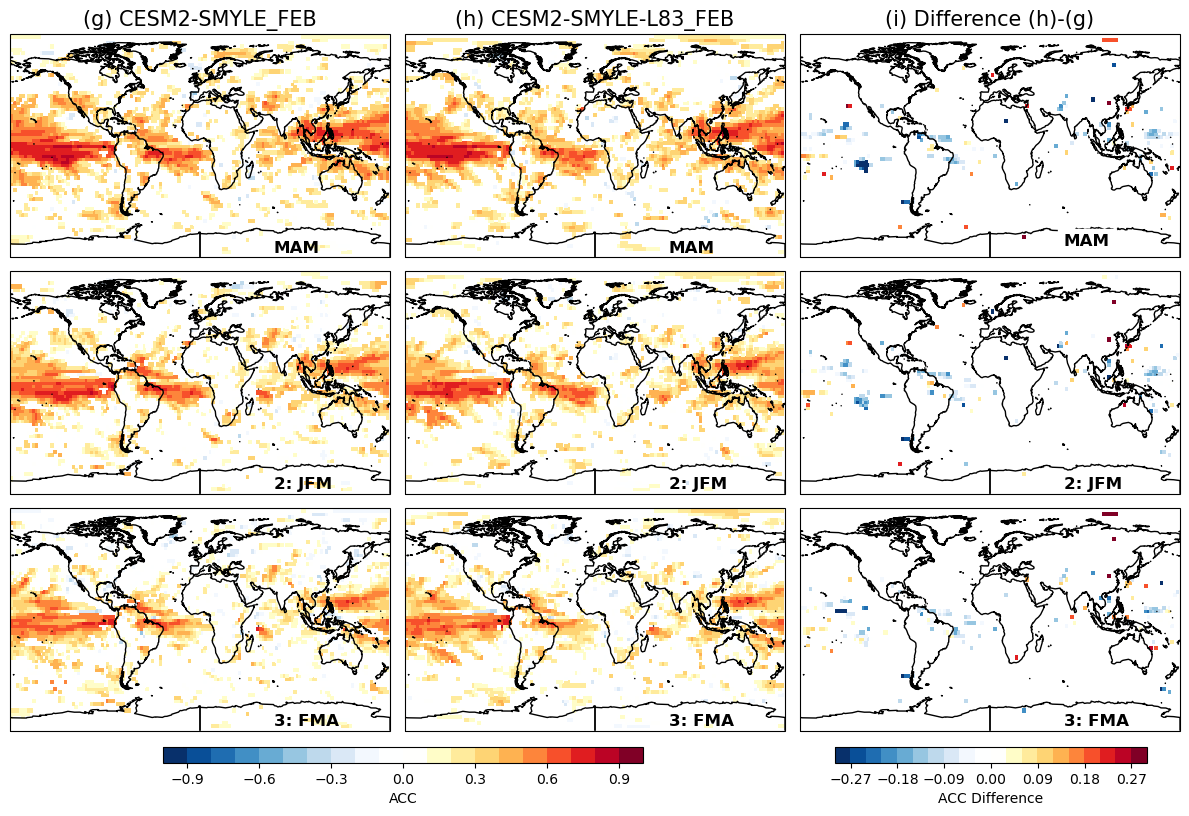

In [385]:
ci = 0.1
cmin = -1
cmax = 1
hatchlevs = [0,0.1,100]
fig = plt.figure(figsize=(12,8))
nrows=3
ncols=3

proj = ccrs.PlateCarree()
#proj = ccrs.Robinson(central_longitude=0)
colstr = ['CESM2-SMYLE_SEP_low top','CESM2-SMYLE_SEP_high top']
ltime = ['1','2','3']
seas11dict = {1:'MAM',2:'JFM',3:'FMA'}
lstr = ''
rstr = ''
fsize=12
fweight='bold'
cmap = "blue2red"
coff = 0.5
siglvl = 0.1
nlevs = (cmax-cmin)/ci + 1
clevs = np.arange(cmin, cmax+ci, ci)
#cmap = mycolors.blue2red_acc_cmap(clevs,0.5)
cmap = mycolors.blue2red_cmap(nlevs)
norm = BoundaryNorm(clevs, ncolors=cmap.N, clip=True)


ax1 = fig.add_subplot(nrows,ncols,1, projection=proj)
ax1.set_aspect('auto')
#ax1.coastlines(resolution='10m')
ax1.add_feature(cartopy.feature.GSHHSFeature(edgecolor='k'))
ax1.set_title('(g) CESM2-SMYLE_FEB', fontsize=15)
ax1.set_facecolor("white")
dat, lon = add_cyclic_point(smyle11_skill.corr.isel(L=0), coord=smyle11_skill.lon)
cntr1 = ax1.pcolormesh(smyle11_skill.lon, smyle11_skill.lat, smyle11_skill.corr.isel(L=0), shading='nearest',vmin=clevs.min(),vmax=clevs.max(),  cmap = cmap, norm=norm, rasterized=True, transform=ccrs.PlateCarree())
ldstr = seas11dict[1]
ax1.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    
ax2 = fig.add_subplot(nrows,ncols,4, projection=proj)
ax2.set_aspect('auto')
ax2.add_feature(cartopy.feature.GSHHSFeature(edgecolor='k'))
ax2.set_title('', fontsize=15)
ax2.set_facecolor("white")
dat, lon = add_cyclic_point(smyle11_skill.corr.isel(L=1), coord=smyle11_skill.lon)
cntr2 = ax2.pcolormesh(smyle11_skill.lon, smyle11_skill.lat, smyle11_skill.corr.isel(L=1), shading='nearest',vmin=clevs.min(),vmax=clevs.max(),  cmap = cmap, norm=norm, rasterized=True, transform=ccrs.PlateCarree())
ldstr = '2: ' + seas11dict[2]
ax2.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)

ax3 = fig.add_subplot(nrows,ncols,7, projection=proj)
ax3.set_aspect('auto')
ax3.add_feature(cartopy.feature.GSHHSFeature(edgecolor='k'))
ax3.set_title('', fontsize=15)
ax3.set_facecolor("white")
dat, lon = add_cyclic_point(smyle11_skill.corr.isel(L=2), coord=smyle11_skill.lon)
cntr3 = ax3.pcolormesh(smyle11_skill.lon, smyle11_skill.lat, smyle11_skill.corr.isel(L=2), shading='nearest',vmin=clevs.min(),vmax=clevs.max(),  cmap = cmap, norm=norm, rasterized=True, transform=ccrs.PlateCarree())
ldstr = '3: ' + seas11dict[3]
ax3.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)

ax1 = fig.add_subplot(nrows,ncols,2, projection=proj)
ax1.set_aspect('auto')
#ax1.coastlines(resolution='10m')
ax1.add_feature(cartopy.feature.GSHHSFeature(edgecolor='k'))
ax1.set_title('(h) CESM2-SMYLE-L83_FEB', fontsize=15)
ax1.set_facecolor("white")
dat, lon = add_cyclic_point(smyle11_high_skill.corr.isel(L=0), coord=smyle11_high_skill.lon)
cntr1 = ax1.pcolormesh(smyle11_high_skill.lon, smyle11_high_skill.lat, smyle11_high_skill.corr.isel(L=0), shading='nearest',vmin=clevs.min(),vmax=clevs.max(),  cmap = cmap, norm=norm, rasterized=True, transform=ccrs.PlateCarree())
ldstr = seas11dict[1]
ax1.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    
ax2 = fig.add_subplot(nrows,ncols,5, projection=proj)
ax2.set_aspect('auto')
ax2.add_feature(cartopy.feature.GSHHSFeature(edgecolor='k'))
ax2.set_title('', fontsize=15)
ax2.set_facecolor("white")
dat, lon = add_cyclic_point(smyle11_high_skill.corr.isel(L=1), coord=smyle11_high_skill.lon)
cntr2 = ax2.pcolormesh(smyle11_high_skill.lon, smyle11_high_skill.lat, smyle11_high_skill.corr.isel(L=1), shading='nearest',vmin=clevs.min(),vmax=clevs.max(),  cmap = cmap, norm=norm, rasterized=True, transform=ccrs.PlateCarree())
ldstr = '2: ' + seas11dict[2]
ax2.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)

ax3 = fig.add_subplot(nrows,ncols,8, projection=proj)
ax3.set_aspect('auto')
ax3.add_feature(cartopy.feature.GSHHSFeature(edgecolor='k'))
ax3.set_title('', fontsize=15)
ax3.set_facecolor("white")
dat, lon = add_cyclic_point(smyle11_high_skill.corr.isel(L=2), coord=smyle11_high_skill.lon)
cntr3 = ax3.pcolormesh(smyle11_high_skill.lon, smyle11_high_skill.lat, smyle11_high_skill.corr.isel(L=2), shading='nearest',vmin=clevs.min(),vmax=clevs.max(),  cmap = cmap, norm=norm, rasterized=True, transform=ccrs.PlateCarree())
ldstr = '3: ' + seas11dict[3]
ax3.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
cbar_ax = fig.add_axes([0.14, 0.04, 0.4, 0.02])
fig.colorbar(cntr1, cax=cbar_ax, label='ACC', orientation='horizontal')

ci = 0.03
cmin = -0.3
cmax = 0.3
nlevs = (cmax-cmin)/ci + 1
clevs = np.arange(cmin, cmax+ci, ci)
cmap = mycolors.blue2red_cmap(nlevs)
norm = BoundaryNorm(clevs, ncolors=cmap.N, clip=True)

ax1 = fig.add_subplot(nrows,ncols,3, projection=proj)
ax1.set_aspect('auto')
#ax1.coastlines(resolution='10m')
ax1.add_feature(cartopy.feature.GSHHSFeature(edgecolor='k'))
ax1.set_title('', fontsize=15)
ax1.set_title('(i) Difference (h)-(g)', fontsize=15)
ax1.set_facecolor("white")
dat, lon = add_cyclic_point(smyle11_skilldiff.corr.isel(L=0), coord=smyle11_skill.lon)
cntr1 = ax1.pcolormesh(smyle11_skill.lon, smyle11_skill.lat, smyle11_skilldiff.corr.isel(L=0), shading='nearest',vmin=clevs.min(),vmax=clevs.max(),  cmap = cmap, norm=norm, rasterized=True, transform=ccrs.PlateCarree())
ldstr = seas11dict[1]
ax1.text(70.,-80,ldstr,fontsize=fsize,fontweight=fweight,backgroundcolor='white',zorder=10)

ax2 = fig.add_subplot(nrows,ncols,6, projection=proj)
ax2.set_aspect('auto')
ax2.add_feature(cartopy.feature.GSHHSFeature(edgecolor='k'))
ax2.set_title('', fontsize=15)
ax2.set_facecolor("white")
dat, lon = add_cyclic_point(smyle11_skilldiff.corr.isel(L=1), coord=smyle11_skill.lon)
cntr2 = ax2.pcolormesh(smyle11_skill.lon, smyle11_skill.lat, smyle11_skilldiff.corr.isel(L=1), shading='nearest',vmin=clevs.min(),vmax=clevs.max(),  cmap = cmap, norm=norm, rasterized=True, transform=ccrs.PlateCarree())
ldstr = '2: ' + seas11dict[2]
ax2.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)

ax3 = fig.add_subplot(nrows,ncols,9, projection=proj)
ax3.set_aspect('auto')
ax3.add_feature(cartopy.feature.GSHHSFeature(edgecolor='k'))
ax3.set_title('', fontsize=15)
ax3.set_facecolor("white")
dat, lon = add_cyclic_point(smyle11_skilldiff.corr.isel(L=2), coord=smyle11_skill.lon)
cntr3 = ax3.pcolormesh(smyle11_skill.lon, smyle11_skill.lat, smyle11_skilldiff.corr.isel(L=2), shading='nearest',vmin=clevs.min(),vmax=clevs.max(),  cmap = cmap, norm=norm, rasterized=True, transform=ccrs.PlateCarree())
ldstr = '3: ' + seas11dict[3]
ax3.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)

#fig.suptitle('Surface temperature skill, linear-detrend',fontsize=20)
fig.tight_layout()
fig.subplots_adjust(bottom=0.08)
cbar_ax = fig.add_axes([0.7, 0.04, 0.26, 0.02])
fig.colorbar(cntr1, cax=cbar_ax, label='ACC Difference', orientation='horizontal')
plt.savefig('Precip_ACC_lineardetrend_comparison_FEB_bootstrap.pdf')